In [1]:
import warnings
warnings.filterwarnings('ignore')

# Domain libraries

Different domain libraries contain data loading functions for different data sources.

| Problem Space         | Pre-build datasets and functions |
| :-------------------: | :------------------------------: |
| Vision                | `torchvision.datasets`           |
| Text                  | `torchtext.datasets`             |
| Audio                 | `torchaudio.datasets`            |
| Recommendation system | `torchrec.datasets`              |
| TorchData (in beta)   | `Torchdata`                      |

Depending on what you are working on, you may want to look into each of the PyTorch domain libraries for existing and customizable data loading functions.

In [2]:
import torch

torch.__version__

'2.1.1'

# Setup device agnostic code

**Note**: Sometimes, depending on your data/hardware, you might find that your model trains faster on CPU than GPU. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# 1. Custom dataset

When starting **machine learning** projects, it is important to try things on a small scale and then increase the scale when necessary. This is especially true when working with large datasets and you need to speed up the experiments. In this notebook, we will learn how to create a custom dataset class for a small dataset using a simplified version of [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset from `torchvision.datasets`, with only three food categories and only 100 images per category.

In [4]:
import pathlib
import torchvision.datasets as datasets

# setup data directory
data_dir = pathlib.Path("data")

# get training and testing data
train_data = datasets.Food101(root=data_dir, split="train", download=True)
test_data = datasets.Food101(root=data_dir, split="test", download=True)

In [5]:
train_data, test_data

(Dataset Food101
     Number of datapoints: 75750
     Root location: data
     split=train,
 Dataset Food101
     Number of datapoints: 25250
     Root location: data
     split=test)

In [6]:
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

'churros'

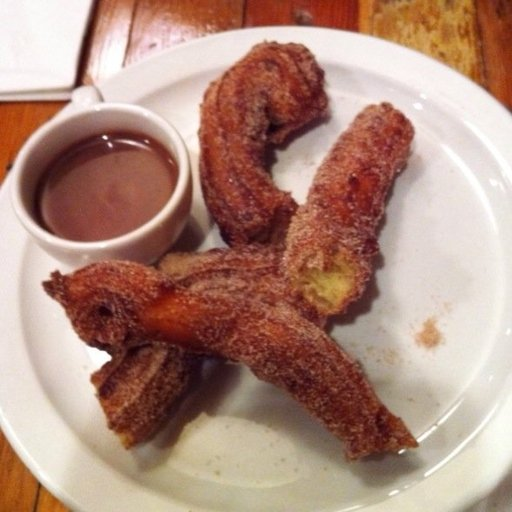

In [7]:
# View first sample (PIL Image format)
image = train_data[0]
display(class_names[image[1]])
image[0]

## 1.1. Becoming one with the data

Preparing and visualizing the data is an important step in the machine learning pipeline. It is important to understand the data format and the range of values in the dataset. This helps in choosing the appropriate preprocessing steps and estimating the range of values that the model needs to predict.

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">“If I had 8 hours to build a machine learning model, I’d spend the first 6 hours preparing my dataset.”<br><br>- Abraham Lossfunction</p>&mdash; Daniel Bourke (@mrdbourke) <a href="https://twitter.com/mrdbourke/status/1456087631641473033?ref_src=twsrc%5Etfw">November 4, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

In [8]:
import random

def get_random_subset(image_path=data_dir / "food-101" / "images",
                      data_splits=["train", "test"], 
                      target_classes=["pizza", "steak", "sushi"],
                      amount=0.1,
                      seed=42):
    random.seed(seed)
    label_splits = {}
    
    # get labels
    for data_split in data_splits:
        label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        with open(label_path, "r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes] 
        
        # get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        sampled_images = random.sample(labels, k=number_to_sample)
        
        # apply full paths
        image_paths = [pathlib.Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits
        
label_splits = get_random_subset()
label_splits.keys(), len(label_splits["train"]), len(label_splits["test"])

(dict_keys(['train', 'test']), 225, 75)

In [9]:
label_splits["train"][:5]

[PosixPath('data/food-101/images/pizza/3269634.jpg'),
 PosixPath('data/food-101/images/pizza/1524655.jpg'),
 PosixPath('data/food-101/images/steak/2825100.jpg'),
 PosixPath('data/food-101/images/steak/225990.jpg'),
 PosixPath('data/food-101/images/steak/1839481.jpg')]

In [10]:
label_splits["test"][:5]

[PosixPath('data/food-101/images/sushi/684266.jpg'),
 PosixPath('data/food-101/images/sushi/988559.jpg'),
 PosixPath('data/food-101/images/sushi/1987407.jpg'),
 PosixPath('data/food-101/images/sushi/3837522.jpg'),
 PosixPath('data/food-101/images/sushi/887831.jpg')]

In [11]:
label_splits["train"][0].parent.stem

'pizza'

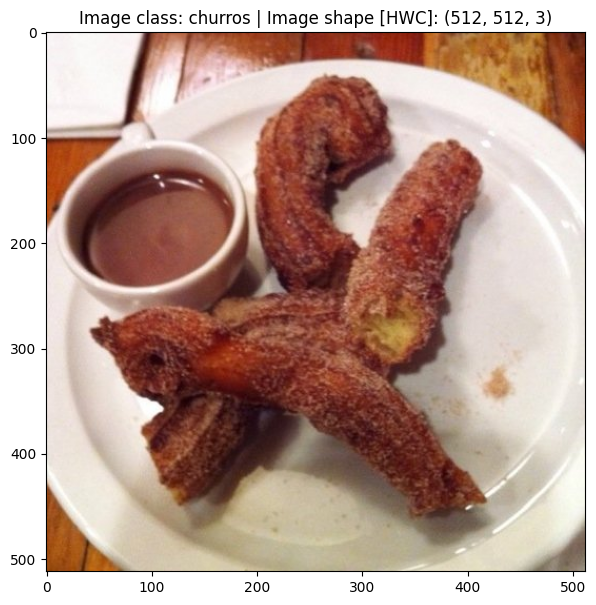

In [12]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.array(image[0])

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {class_names[image[1]]} | Image shape [HWC]: {img_as_array.shape}");

## 1.2. Move training and testing images to dedicated folder

In [13]:
target_dir = pathlib.Path("data/food-101/pizza-steak-sushi")
target_dir.mkdir(parents=True, exist_ok=True)

In [14]:
import shutil

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(image_path, dest_dir)

In [15]:
import os

for dirpath, dirnames, filenames in os.walk(target_dir):
  if len(dirnames) == 0:
    print(f"There are {len(filenames)} images in '{dirpath}'.")

There are 19 images in 'data/food-101/pizza-steak-sushi/test/steak'.
There are 31 images in 'data/food-101/pizza-steak-sushi/test/sushi'.
There are 25 images in 'data/food-101/pizza-steak-sushi/test/pizza'.
There are 75 images in 'data/food-101/pizza-steak-sushi/train/steak'.
There are 72 images in 'data/food-101/pizza-steak-sushi/train/sushi'.
There are 78 images in 'data/food-101/pizza-steak-sushi/train/pizza'.


# 2. Transforming data with `torchvision.transforms`

The data is in the height, width, color channels format (HWC). However, PyTorch expects the color channels to be first (CHW). In order to make the data compatible with PyTorch, we need to turn data into tensors using the `torchvision.transforms.ToTensor` class, then turn it into a `torch.utils.data.Dataset` subclass and subsequently a `torch.utils.data.DataLoader`.

Another option is to use the `ImageFolder` base class from PyTorch that implements the `transform` method to transform a PIL image into a tensor. We can use this method to transform the data into tensors.

In [16]:
from torchvision import transforms

test_data_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),        # resize the image to 64x64 (to speed up training)
    transforms.ToTensor(),                   # convert image to tensors
])

test_data_transforms(image[0]).shape, test_data_transforms(image[0]).type()

(torch.Size([3, 64, 64]), 'torch.FloatTensor')

## 2.1. Data augmentation

In the blog post [How to Train State-Of-The-Art Models Using TorchVision’s Latest Primitives](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/), it is presented an original model trained using basic augmentation transforms, such as random resized crops and horizontal flips, and an improved model trained using more complex “Automatic-Augmentation” techniques. The one that performed best was `TrivialAugment`, which is extremely simple and can be considered “parameter free”, a big advantage since there are no hyper-parameters to optimize, which cuts down the search space.

`TrivialAugment` was presented in the paper [TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation](https://arxiv.org/pdf/2103.10158.pdf) and boils down to randomly applying one of a list of simple transforms.

In [17]:
train_data_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),       # apply trivial augmentations (data augmentation)
    *test_data_transforms.transforms 
])

train_data_transforms(image[0]).shape, train_data_transforms(image[0]).type()

(torch.Size([3, 64, 64]), 'torch.FloatTensor')

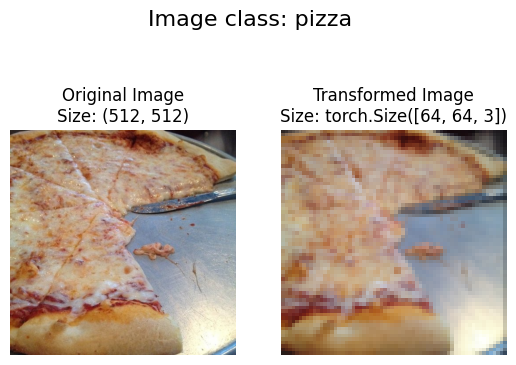

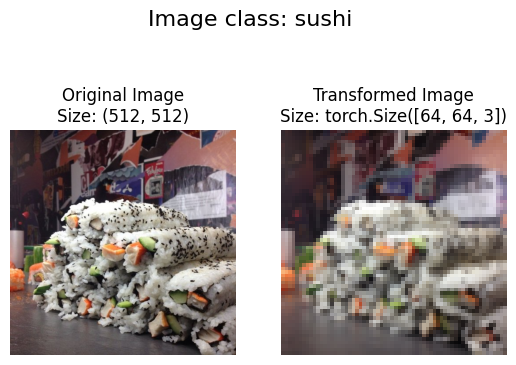

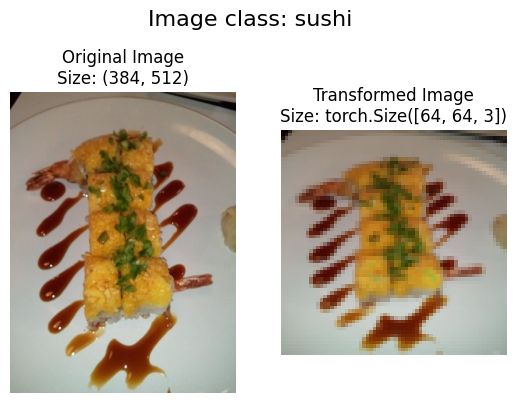

In [18]:
from PIL import Image

def plot_transformed_images(image_paths: list, transform: transforms.Compose, n: int = 3, seed: int = None):
    """Plots n number of images after applying the transform"""
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original Image\nSize: {img.size}")
            ax[0].set_axis_off()

            transformed_img = transform(img).permute(1, 2, 0)
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed Image\nSize: {transformed_img.shape}")
            ax[1].set_axis_off()

            fig.suptitle(f"Image class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=label_splits["train"], transform=train_data_transforms)

# 3. Loading data into `Datasets`

## 3.1. Loading image data using `ImageFolder`

In [19]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=target_dir / "train", transform=train_data_transforms)
test_data = ImageFolder(root=target_dir / "test", transform=test_data_transforms)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/food-101/pizza-steak-sushi/train
     StandardTransform
 Transform: Compose(
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/food-101/pizza-steak-sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

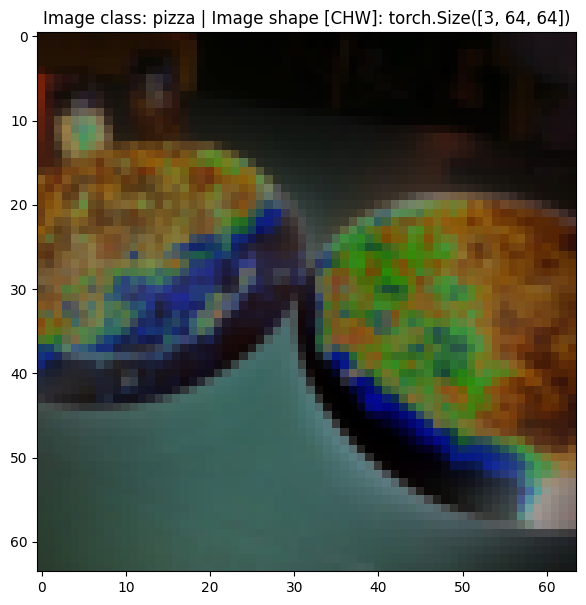

In [20]:
plt.figure(figsize=(10, 7))
plt.imshow(np.array(train_data[0][0].permute(1, 2, 0)))
plt.title(f"Image class: {train_data.classes[train_data[0][1]]} | Image shape [CHW]: {train_data[0][0].shape}");

## 3.2. Loading image data using custom `Dataset` class

All datasets that represent a map from keys to data samples should subclass `torch.utils.data.Dataset` and override `__getitem__`, supporting fetching a data sample for a given key. Subclasses could optionally override `__len__`, which is expected to return the size of the dataset by many `torch.utils.data` utilities.

Let's create a custom dataset class for the Food101 dataset.

In [21]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose
from typing import Tuple, List, Dict

class ImageFolderCustom(Dataset):
  def __init__(self, target_dir: str, transform: Compose = None):
    super().__init__()
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = self.find_classes(target_dir)


  def __len__(self) -> int:
    """Returns the total number of images in the dataset."""
    return len(self.paths)
  

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Returns the image and its label at the given index."""
    image = self.load_image(index)

    class_name = self.paths[index].parent.stem
    class_index = self.class_to_idx[class_name]

    if self.transform:
      image = self.transform(image)
    return image, class_index


  def load_image(self, image_index: int) -> Image.Image:
    """Loads an image from a file path and returns it."""
    image_path = self.paths[image_index]
    return Image.open(image_path)


  def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""
    
    # get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # raise an error if class names could not be found
    if not classes:
      raise FileNotFoundError(f"Could not find any class folders in {directory}.")
    
    # create a dictionary of index labels
    class_to_idx = {cls_name: index for index, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [22]:
train_data_custom = ImageFolderCustom(target_dir=target_dir / "train", transform=train_data_transforms)
test_data_custom = ImageFolderCustom(target_dir=target_dir / "test", transform=test_data_transforms)

len(train_data_custom), len(test_data_custom)

(225, 75)

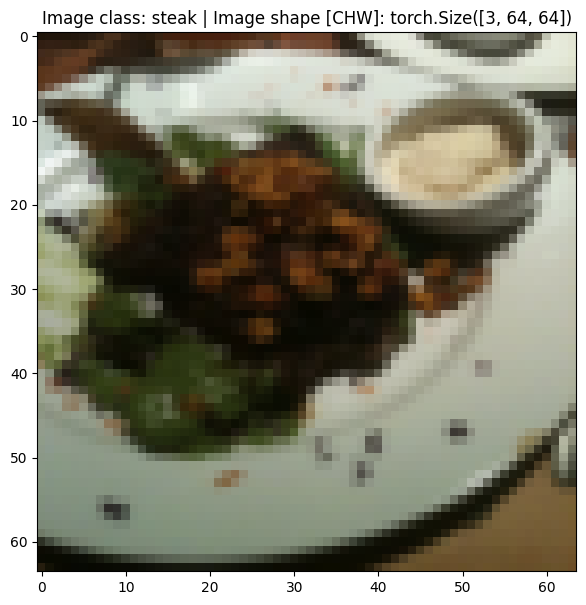

In [23]:
plt.figure(figsize=(10, 7))
plt.imshow(np.array(train_data_custom[0][0].permute(1, 2, 0)))
plt.title(f"Image class: {train_data_custom.classes[train_data_custom[0][1]]} | Image shape [CHW]: {train_data_custom[0][0].shape}");

# 4. Building and evaluating models

## 4.1. Tiny VGG without data augmentation

### 4.1.1. Turning images into `Dataloader` batches

In [24]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# setup data transformation pipeline
simple_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# load and transform data
train_data = ImageFolder(root=target_dir / "train", transform=simple_transforms)
test_data = ImageFolder(root=target_dir / "test", transform=simple_transforms)

# setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# create data loaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

len(train_dataloader), len(test_dataloader)

(8, 3)

### 4.1.2. Creating a tiny VGG model

In [25]:
from torch import nn

class TinyVGG(nn.Module):
    """
      A simple convolutional neural network model
      that repicates the Tiny VGG architecture

        Args:
            input_channels (int): the number of channels in the input
            hidden_units (int): the number of hidden units in the hidden layer
            output_shape (int): the number of classes in the output

        Components:
            conv_block_*: feature extractor block (convolutional block)
            classifier: classifier block for output prediction
    """
    def __init__(self, input_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_alfa = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_beta = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block_beta(self.conv_block_alfa(x)))

In [26]:
torch.manual_seed(42)
model_0 = TinyVGG(input_channels=3, hidden_units=32, output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_alfa): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_beta): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=3, bias=True)
  )
)

### 4.1.3. Testing the model on a single batch

In [27]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [28]:
preds = model_0(image_batch.to(device))
preds.shape, preds[0]

(torch.Size([32, 3]),
 tensor([0.1242, 0.1490, 0.0161], grad_fn=<SelectBackward0>))

In [29]:
from torchinfo import summary

summary(model_0, input_size=image_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 32, 64, 64]          896
│    └─ReLU: 2-2                         [32, 32, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 32, 64, 64]          9,248
│    └─ReLU: 2-4                         [32, 32, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 32, 32, 32]          --
├─Sequential: 1-2                        [32, 32, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 32, 32, 32]          9,248
│    └─ReLU: 2-7                         [32, 32, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 32, 32, 32]          9,248
│    └─ReLU: 2-9                         [32, 32, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 32, 16, 16]          --
├─Seq

### 4.1.4. Training and evaluation loop

In [30]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
import torchmetrics

def train_model(
        model: torch.nn.Module, 
        loss_fn: torch.nn.Module, 
        optim: torch.optim.Optimizer, 
        accuracy: torchmetrics.Metric, 
        f1: torchmetrics.Metric, 
        train_dataloader: DataLoader, 
        test_dataloader: DataLoader, 
        epochs: int = 5,
        model_name: str = "baseline-model"):
    """Performs training and evaluation of the model"""

    total_train_time = 0

    for epoch in tqdm(range(epochs)):
        start = timer()

        # training
        train_loss_per_batch = train_acc_per_batch = train_f1_per_batch = 0

        model.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)

            # forward pass
            logits = model(X)
            loss = loss_fn(logits, y)
            train_loss_per_batch += loss.item()

            # backward pass
            optim.zero_grad()
            loss.backward()

            # update parameters
            optim.step()

            # calculate accuracy and f1 score
            train_acc_per_batch += accuracy(logits.softmax(dim=1), y).item()
            train_f1_per_batch += f1(logits.softmax(dim=1), y).item()

        train_loss_per_batch /= len(train_dataloader)
        train_acc_per_batch /= len(train_dataloader)
        train_f1_per_batch /= len(train_dataloader)

        # testing
        test_loss_per_batch = test_acc_per_batch = test_f1_per_batch = 0

        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)

                # forward pass
                logits = model(X)
                loss = loss_fn(logits, y)
                test_loss_per_batch += loss.item()

                # calculate accuracy and f1 score
                test_acc_per_batch += accuracy(logits.softmax(dim=1), y).item()
                test_f1_per_batch += f1(logits.softmax(dim=1), y).item()

        test_loss_per_batch /= len(test_dataloader)
        test_acc_per_batch /= len(test_dataloader)
        test_f1_per_batch /= len(test_dataloader)

        end = timer()
        total_train_time += end - start
        print(f"Epoch: {epoch + 1}/{epochs}, "
                f"train_loss: {train_loss_per_batch:.4f}, test_loss: {test_loss_per_batch:.4f}, "
                f"train_acc: {train_acc_per_batch:.4f}, test_acc: {test_acc_per_batch:.4f}, "
                f"train_f1: {train_f1_per_batch:.4f}, test_f1: {test_f1_per_batch:.4f}, "
                f"time: {end - start:.2f}s")
        
    return {
        "train_loss": train_loss_per_batch,
        "train_acc": train_acc_per_batch,
        "train_f1": train_f1_per_batch,
        "test_loss": test_loss_per_batch,
        "test_acc": test_acc_per_batch,
        "test_f1": test_f1_per_batch,
        "total_train_time": total_train_time,
        "model_name": model_name
    }

In [31]:
from torchmetrics import Accuracy, F1Score

# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

# pick loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# define eval metrics
accuracy = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)
f1 = F1Score(task="multiclass", num_classes=len(train_data.classes)).to(device)

# train model
model0_metrics = train_model(model_0, loss_fn, optim, accuracy, f1, train_dataloader, test_dataloader, model_name="tiny_vgg_without_augmentation")

 20%|██        | 1/5 [01:02<04:10, 62.74s/it]

Epoch: 1/5, train_loss: 1.0967, test_loss: 1.1355, train_acc: 0.2891, test_acc: 0.2604, train_f1: 0.2891, test_f1: 0.2604, time: 62.75s


 40%|████      | 2/5 [02:05<03:07, 62.48s/it]

Epoch: 2/5, train_loss: 1.0887, test_loss: 1.1474, train_acc: 0.4258, test_acc: 0.2604, train_f1: 0.4258, test_f1: 0.2604, time: 62.29s


 60%|██████    | 3/5 [03:07<02:04, 62.46s/it]

Epoch: 3/5, train_loss: 1.0873, test_loss: 1.1538, train_acc: 0.4258, test_acc: 0.2604, train_f1: 0.4258, test_f1: 0.2604, time: 62.44s


 80%|████████  | 4/5 [04:09<01:02, 62.35s/it]

Epoch: 4/5, train_loss: 1.1148, test_loss: 1.1559, train_acc: 0.3047, test_acc: 0.2604, train_f1: 0.3047, test_f1: 0.2604, time: 62.17s


100%|██████████| 5/5 [05:12<00:00, 62.43s/it]

Epoch: 5/5, train_loss: 1.0912, test_loss: 1.1562, train_acc: 0.4258, test_acc: 0.2604, train_f1: 0.4258, test_f1: 0.2604, time: 62.48s


In [32]:
model0_metrics

{'train_loss': 1.0912346988916397,
 'train_acc': 0.42578125,
 'train_f1': 0.42578125,
 'test_loss': 1.1562373439470928,
 'test_acc': 0.2604166666666667,
 'test_f1': 0.2604166666666667,
 'total_train_time': 312.11695391600006,
 'model_name': 'tiny_vgg_without_augmentation'}

## 4.2. Tiny VGG with data augmentation

In [33]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# setup data transformation pipelines
test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),       # apply trivial augmentations (data augmentation)
    *test_transforms.transforms 
])

# load and transform data
train_data = ImageFolder(root=target_dir / "train", transform=train_transforms)
test_data = ImageFolder(root=target_dir / "test", transform=test_transforms)

# setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# create data loaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

len(train_dataloader), len(test_dataloader)

(8, 3)

In [34]:
from torchmetrics import Accuracy, F1Score

# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

# setup model
model_1 = TinyVGG(input_channels=3, hidden_units=32, output_shape=len(train_data.classes)).to(device)

# pick loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# define eval metrics
accuracy = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)
f1 = F1Score(task="multiclass", num_classes=len(train_data.classes)).to(device)

# train model
model1_metrics_with_augmentation = train_model(model_1, loss_fn, optim, accuracy, f1, train_dataloader, test_dataloader, model_name="tiny_vgg_without_augmentation")

 20%|██        | 1/5 [01:02<04:10, 62.75s/it]

Epoch: 1/5, train_loss: 1.1098, test_loss: 1.0892, train_acc: 0.2617, test_acc: 0.5417, train_f1: 0.2617, test_f1: 0.5417, time: 62.75s


 40%|████      | 2/5 [02:05<03:07, 62.67s/it]

Epoch: 2/5, train_loss: 1.1020, test_loss: 1.1073, train_acc: 0.2539, test_acc: 0.2604, train_f1: 0.2539, test_f1: 0.2604, time: 62.61s


 60%|██████    | 3/5 [03:07<02:04, 62.49s/it]

Epoch: 3/5, train_loss: 1.0904, test_loss: 1.1245, train_acc: 0.4258, test_acc: 0.2604, train_f1: 0.4258, test_f1: 0.2604, time: 62.29s


 80%|████████  | 4/5 [04:10<01:02, 62.50s/it]

Epoch: 4/5, train_loss: 1.1126, test_loss: 1.1405, train_acc: 0.3047, test_acc: 0.2604, train_f1: 0.3047, test_f1: 0.2604, time: 62.52s


100%|██████████| 5/5 [05:12<00:00, 62.60s/it]

Epoch: 5/5, train_loss: 1.0936, test_loss: 1.1446, train_acc: 0.4258, test_acc: 0.2604, train_f1: 0.4258, test_f1: 0.2604, time: 62.81s


In [35]:
model1_metrics_with_augmentation

{'train_loss': 1.0935791432857513,
 'train_acc': 0.42578125,
 'train_f1': 0.42578125,
 'test_loss': 1.1445502638816833,
 'test_acc': 0.2604166666666667,
 'test_f1': 0.2604166666666667,
 'total_train_time': 312.9726029160002,
 'model_name': 'tiny_vgg_without_augmentation'}

# 5. Making predictions

To make a prediction, the data must be in the same format that the model was trained on. Therefore, we need to apply the same transformations to the new data as we did to the training data.

In [36]:
import requests

custom_image_path = data_dir / "custom" / "pizza.jpg"

custom_image_path.parent.mkdir(parents=True, exist_ok=True)

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    f.write(requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg").content)

In [37]:
from torchvision.io import read_image

custom_image_uint8 = read_image(str(custom_image_path))
custom_image_uint8.shape, custom_image_uint8.dtype

(torch.Size([3, 4032, 3024]), torch.uint8)

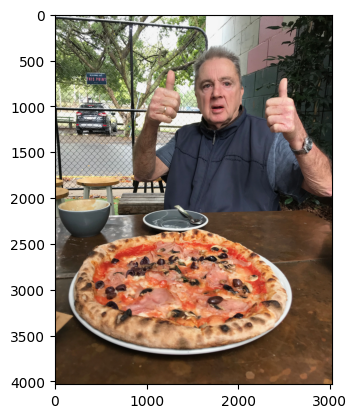

In [38]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

In [39]:
# setup data transformation pipeline
pred_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ConvertImageDtype(torch.float32),
])

custom_image_transformed = pred_transforms(custom_image_uint8)
custom_image_transformed.shape, custom_image_transformed.dtype

(torch.Size([3, 64, 64]), torch.float32)

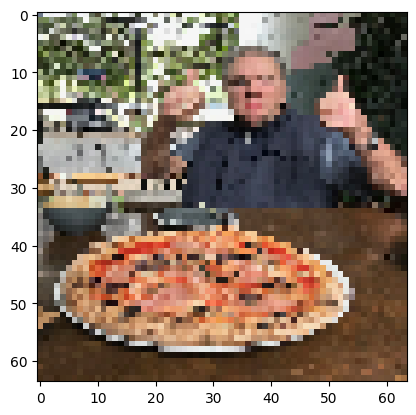

In [40]:
plt.imshow(custom_image_transformed.permute(1, 2, 0));

In [47]:
model_1.eval()
with torch.inference_mode():
  sample = torch.unsqueeze(custom_image_transformed, dim=0).to(device)
  logit = model_1(sample)
  pred_probs = torch.softmax(logit, dim=1).cpu()
  pred = torch.argmax(pred_probs, dim=1).item()

train_data.classes[pred]

'pizza'

# References

1. [Pytorch Documentation - How to Train SOTA Models Using TorchVision’s Latest Primitives](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)
2. [Ground Truth Notebook](https://www.learnpytorch.io/04_pytorch_custom_datasets/)